In [2]:
# Imports
from __future__ import print_function
import numpy as np
import scipy.sparse as sp
import scipy

# saving/loading simulated data
import pickle as pk

# Dougal code imports
from skl_groups.features import Features
from sklearn.pipeline import Pipeline
from skl_groups.divergences import KNNDivergenceEstimator
from skl_groups.kernels import PairwisePicker, Symmetrize, RBFize, ProjectPSD
import mmd  # conda install -c dougal mmd
from sklearn.metrics.pairwise import euclidean_distances

# for post-kernel generation analysis
from sklearn import manifold
from sklearn.manifold import LocallyLinearEmbedding
import seaborn as sns
from mpl_toolkits.axes_grid1 import *


import matplotlib.pyplot as plt
%matplotlib inline

# Helper Functions

In [22]:
# load kernel file
def loadSimilarities(fn):
    """
    Load the previously saved similarity matrix from a .npz file

    Inputs:
    - fn: directory/filename (minus extension) to load the file from

    Returns:
    - loadedSims: similarity matrix
    """
    loader = np.load(fn+".npz")
    print("Similarities loaded!")
    return loader['similarities']

# Note: loaded kernel is the result of
# - building the KNN graph using KL divergence
# - symmeterizing the graph: KL is not a distance and is not symmetric, we need distance-symmetry behavior because next step is...
# - passing the symmeterized graph through a radial basis function (RBF): Since the value of the RBF kernel decreases with distance and ranges between zero (in the limit) and one (when x = x'), it has a ready interpretation as a similarity measure
# - projecting the output of the RBF to a positive semi-definite space: 

def loadSimFeats(fn):
    """
    Load a previously saved simulated subject from a .npz file.

    Inputs:
    - fn: filename/directory to load from (extensionless)

    Returns:
    - features: single patient's features/nodes
    - ids: subject ids
    - y: the label (number of abnormal nodes)
    """
    with open(fn+"-feats.data.p", "rb") as f:
        loader = pk.load(f)
    f.close()
    print("Simluated patient features and metadata loaded!")
    return loader['ids'], np.asarray(loader['y']), loader['features']

def  plotLowDimWithColor( nodes2D, subjColor, 
                         ax=None, plotTitle=None, markerSize=2 ):
    """
    plot low dimensional embedding
    
    Inputs:
    - nodes2D: subset of patients that came from a higher dimensional space and need to be plotted in 2D for visualization
    - subjColor: number of abnormal nodes in each simulated patient
    
    Returns: nothing
    Effect: plots a scatter plot
    """
    inFeature = nodes2D

    # normalize the colors to a good range
    maxVal = -np.sort(-np.asarray(subjColor))[0]
    minVal = np.sort(np.asarray(subjColor))[0]
    cm = plt.cm.get_cmap('RdYlBu_r')
    print(subjColor)
    
    if ax==None:
        scatter(inFeature[:,0], inFeature[:,1], c=subjColor, 
                lw = 0, vmin=minVal, vmax=maxVal,  
                cmap=cm, s=markerSize )
        colorbar()
        plt.xlim(np.percentile(inFeature[:,0], 1, axis=0), 
                 np.percentile(inFeature[:,0], 99, axis=0))
        plt.ylim(np.percentile(inFeature[:,1], 1, axis=0), 
                 np.percentile(inFeature[:,1], 99, axis=0))   
        plt.title(plotTitle)      
    else:
        scPlot = ax.scatter(inFeature[:,0], inFeature[:,1], c=np.asarray(subjColor), 
                lw = 0, vmin=minVal, vmax=maxVal,  
                cmap=cm, s=markerSize  )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scPlot, cax=cax)
        ax.set_xlim(np.percentile(inFeature[:,0], 1, axis=0), 
                 np.percentile(inFeature[:,0], 99, axis=0))
        ax.set_ylim(np.percentile(inFeature[:,1], 1, axis=0), 
                 np.percentile(inFeature[:,1], 99, axis=0)) 
        ax.set_title(plotTitle)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
# Helper functions
def evalFeatures_Regression(XTrain,yTrain,XTest,yTest,m):
    """
    evaluate a regression model
    """

    # scaling
    stdScaler = StandardScaler()
    stdScaler.fit(XTrain)
    XTrain = stdScaler.transform(XTrain)
    yTrain = np.log10(yTrain)
    XTest = stdScaler.transform(XTest)
    yTest = np.log10(yTest)
        
    m.fit(XTrain, yTrain)
    pred_y = m.predict(XTest)
    r2 = metrics.r2_score(yTest, pred_y)
    s = metrics.mean_squared_error(yTest, pred_y)
    return r2, s, pred_y

def loadSimImg(fn):
    """
    Load a previously saved simulated subject from a .npz file.

    Inputs:
    - fn: filename/directory to load from (extensionless)

    Returns:
    - images: single patient's features/nodes
    """
    loader = np.load(fn+".npz")
#     print "Image " + fn + " loaded!"
    return loader['image']

def confidenceInterval(colNameList, scores):
    """
    Compute the confidence interval of the data
    Source: http://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot
    
    Inputs:
    - x: xAxis data
    - y: y axis data
    
    Returns
    - CI: confidence interval
    """
    import scikits.bootstrap as boot
    upperlimits  = np.zeros(len(colNameList),)
    lowerlimits = np.zeros(len(colNameList),)
    r2Mean = np.zeros(len(colNameList),)
    halfDelta = np.zeros(len(colNameList),)
    for i in range(len(colNameList)):
        l,u = boot.ci( np.array(scores), np.mean)
        upperlimits[i] = u
        lowerlimits[i] = l
        r2Mean[i] = (u+l)/2.0
        halfDelta = (u-l)/2.0
    return np.array(range(2,numPCA_comp,10)), r2Mean, halfDelta

# Start by loading data for KL, HE, and MMD

In [42]:
kernelFN = "/home/jms565/Research/COPDImageAnalysis/simulatedData/kernel-2000-sym-v2"
# kernelFN = "/home/jms565/Research/COPDImageAnalysis/simulatedData/kernel-2000-sym-pix-kl"
kl_sym = loadSimilarities(kernelFN)
kernelFN = "/home/jms565/Research/COPDImageAnalysis/simulatedData/kernel-2000-sym-he"
# kernelFN = "/home/jms565/Research/COPDImageAnalysis/simulatedData/kernel-2000-sym-pix-he"
he_sym = loadSimilarities(kernelFN)

kernelFN = "/home/jms565/Research/COPDImageAnalysis/simulatedData/kernel-matrix-mmd-gammas-1-med"
mmd_sym = loadSimilarities(kernelFN)

assert (kl_sym == kl_sym.T).all()
assert (he_sym == he_sym.T).all()
assert (mmd_sym == mmd_sym.T).all()

Similarities loaded!
Similarities loaded!
Similarities loaded!


# Need to RBFize and ProjectPSD the KL and HE

In [47]:
# RBFize
rbf = RBFize(gamma=1, scale_by_median=False)

kl_sym_median = np.median(kl_sym[np.triu_indices_from(kl_sym)])
kl_sym2 = kl_sym/kl_sym_median
kl_rbf = rbf.fit_transform(kl_sym2)

he_sym_median = np.median(he_sym[np.triu_indices_from(he_sym)])
he_sym2 = he_sym/he_sym_median
he_rbf = rbf.fit_transform(np.nan_to_num(he_sym2))

print(kl_rbf.min(), np.median(kl_rbf), kl_rbf.max())
print(he_rbf.min(), np.median(he_rbf), he_rbf.max())

# ProjectPSD
psd = ProjectPSD()
kernelKL = psd.fit_transform(kl_rbf)
kernelHE = psd.fit_transform(he_rbf)
kernelMMD = mmd_sym

0.0 0.367091 1.0
0.0 1.0 1.0


# Cholesky Factorization

In [48]:
regParam = 1e-3
hidimKL = np.linalg.cholesky(kernelKL+(regParam*np.eye(kernelKL.shape[0])))
hidimHE = np.linalg.cholesky(kernelHE+(regParam*np.eye(kernelHE.shape[0])))
hidimMMD = np.linalg.cholesky(kernelMMD+(regParam*np.eye(kernelMMD.shape[0])))

# TSNE

In [49]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)  # 
tSNEKL = tsne.fit_transform(hidimKL)   # hidim is the cholesky factorization
tSNEHE = tsne.fit_transform(hidimHE)
tSNEMMD = tsne.fit_transform(hidimMMD)

In [50]:
patientsFN = "/home/jms565/Research/COPDImageAnalysis/simulatedData/simulatedSubjects"
# patientsFN = "/pylon2/ms4s88p/jms565/projects/MNISTSubjects/simulatedSubjects"
subjIds, numAbnormalNodes, loadedFeats = loadSimFeats(patientsFN)

Simluated patient features and metadata loaded!


# Plot TSNE in 2D

[ 254.28421345  311.0283739   268.39480127 ...,  287.72574732  340.86635409
  322.30688605]
[ 254.28421345  311.0283739   268.39480127 ...,  287.72574732  340.86635409
  322.30688605]
[ 254.28421345  311.0283739   268.39480127 ...,  287.72574732  340.86635409
  322.30688605]


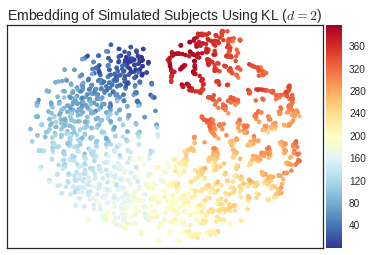

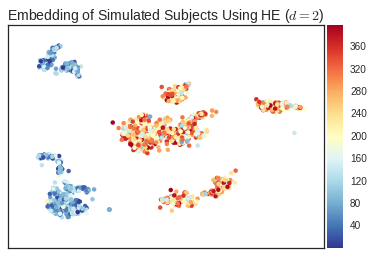

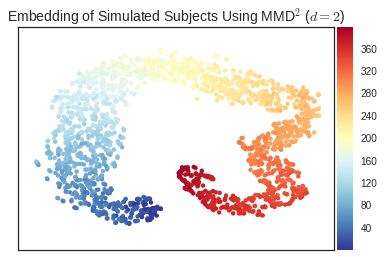

In [57]:
permIdx = np.random.permutation(range(len(subjIds)))
N = 2000
tSNEKL_subset = tSNEKL[permIdx[:N]]
tSNEHE_subset = tSNEHE[permIdx[:N]]
tSNEMMD_subset = tSNEMMD[permIdx[:N]]
subjClasses_subset = numAbnormalNodes[permIdx[:N]]

# Plot KL
with sns.axes_style("white"):
    f, ax1 = plt.subplots()
plotLowDimWithColor(tSNEKL_subset, subjClasses_subset, ax=ax1, plotTitle='tSNE', markerSize=20)
ax1.set_xlim([-22,20])
ax1.set_ylim([-18,20])
ax1.set_title('Embedding of Simulated Subjects Using KL ($d=2$)',fontsize=14)

f.savefig("tsne-kl-v1.pdf", bbox_inches='tight')

# Plot HE
with sns.axes_style("white"):
    f, ax1 = plt.subplots()
plotLowDimWithColor(tSNEHE_subset, subjClasses_subset, ax=ax1, plotTitle='tSNE', markerSize=20)
ax1.set_xlim([-18,16])
ax1.set_ylim([-20,16])
ax1.set_title('Embedding of Simulated Subjects Using HE ($d=2$)',fontsize=14)

f.savefig("tsne-he-v1.pdf", bbox_inches='tight')

# Plot MMD
with sns.axes_style("white"):
    f, ax1 = plt.subplots()
plotLowDimWithColor(tSNEMMD_subset, subjClasses_subset, ax=ax1, plotTitle='tSNE', markerSize=20)
ax1.set_xlim([-15,15])
ax1.set_ylim([-20,20])
ax1.set_title('Embedding of Simulated Subjects Using MMD$^2$ ($d=2$)',fontsize=14)

f.savefig("tsne-mmd-v1.pdf", bbox_inches='tight')

# Now perform LLE